# DELFI-C3 - Parameter Estimation
Copyright (c) 2010-2022, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please or visit: http://tudat.tudelft.nl/LICENSE.

## Context
This example highlights the basic steps of setting up an orbit estimation routine. In particular, note that within this example we will focus on how to set up and perform the full estimation of a spacecraft's initial state, drag coefficient, and radiation pressure coefficient. For the propagation of the covariance matrix over the course of the spacecraft's orbit see the [Delfi-C3 Covariance Analysis example](https://docs.tudat.space/en/latest/_src_getting_started/_src_examples/notebooks/estimation/covariance_estimated_parameters.html).

Have you already followed the covariance example? Then you might want to skip the first part of this example dealing with the setup of all relevant (environment, propagation, and estimation) modules and dive straight in to the full [estimation](#estimation_section) of all chosen parameters.

To simulate the orbit of a spacecraft, we will fall back and reiterate on all aspects of orbit propagation that are important within the scope of orbit estimation. Further, we will highlight all relevant features of modelling a tracking station on Earth. Using this station, we will simulate a tracking routine of the spacecraft using a series of open-loop Doppler range-rate measurements at 1 mm/s every 60 seconds. To assure an uninterrupted line-of-sight between the station and the spacecraft, a minimum elevation angle of more than 15 degrees above the horizon - as seen from the station - will be imposed as constraint on the simulation of observations.

## Import statements
Typically - in the most pythonic way - all required modules are imported at the very beginning.

Some standard modules are first loaded: `numpy` and `matplotlib.pyplot`.

Then, the different modules of `tudatpy` that will be used are imported. Most notably, the `estimation`, `estimation_setup`, and `observations` modules will be used and demonstrated within this example.

In [2]:
# Load required standard modules
import numpy as np
from matplotlib import pyplot as plt

# Load required tudatpy modules
from tudatpy import constants
from tudatpy.interface import spice
from tudatpy import numerical_simulation
from tudatpy.numerical_simulation import environment
from tudatpy.numerical_simulation import environment_setup
from tudatpy.numerical_simulation import propagation_setup
from tudatpy.numerical_simulation import estimation, estimation_setup
from tudatpy.numerical_simulation.estimation_setup import observation
from tudatpy.astro.time_conversion import DateTime
from tudatpy.astro import element_conversion

## Configuration
First, NAIF's `SPICE` kernels are loaded, to make the positions of various bodies such as the Earth, the Sun, or the Moon known to `tudatpy`.

Subsequently, the start and end epoch of the simulation are defined. Note that using `tudatpy`, the times are generally specified in seconds since J2000. Hence, setting the start epoch to `0` corresponds to the 1st of January 2000. The end epoch specifies a total duration of the simulation of three days.

For more information on J2000 and the conversion between different temporal reference frames, please refer to the API documentation of the [`time_conversion module`](https://tudatpy.readthedocs.io/en/latest/time_conversion.html).

In [3]:
# Load spice kernels
spice.load_standard_kernels()

# Set simulation start and end epochs
simulation_start_epoch = DateTime(2000, 1, 1).epoch()
simulation_end_epoch   = DateTime(2000, 1, 4).epoch()

## Set up the environment
We will now create and define the settings for the environment of our simulation. In particular, this covers the creation of (celestial) bodies, vehicle(s), and environment interfaces.

### Create the main bodies
To create the systems of bodies for the simulation, one first has to define a list of strings of all bodies that are to be included. Note that the default body settings (such as atmosphere, body shape, rotation model) are taken from the `SPICE` kernel.

These settings, however, can be adjusted. Please refer to the [Available Environment Models](https://tudat-space.readthedocs.io/en/latest/_src_user_guide/state_propagation/environment_setup/create_models/available.html#available-environment-models) in the user guide for more details.

Finally, the system of bodies is created using the settings. This system of bodies is stored into the variable `bodies`.

In [4]:
# Create default body settings for "Sun", "Earth", "Moon", "Mars", and "Venus"
bodies_to_create = ["Sun", "Earth", "Moon", "Mars", "Venus"]

# Create default body settings for bodies_to_create, with "Earth"/"J2000" as the global frame origin and orientation
global_frame_origin = "Earth"
global_frame_orientation = "J2000"
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)

# Create system of bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

### Create the vehicle and its environment interface
We will now create the satellite - called Delfi-C3 - for which an orbit will be simulated. Using an `empty_body` as a blank canvas for the satellite, we define mass of 400kg, a reference area (used both for aerodynamic and radiation pressure) of 4m$^2$, and a aerodynamic drag coefficient of 1.2. Idem for the radiation pressure coefficient. Finally, when setting up the radiation pressure interface, the Earth is set as a body that can occult the radiation emitted by the Sun.

In [5]:
# Create vehicle objects.
bodies.create_empty_body("Delfi-C3")
bodies.get("Delfi-C3").mass = 2.2

# Create aerodynamic coefficient interface settings
reference_area = (4*0.3*0.1+2*0.1*0.1)/4  # Average projection area of a 3U CubeSat
drag_coefficient = 1.2
aero_coefficient_settings = environment_setup.aerodynamic_coefficients.constant(
    reference_area, [drag_coefficient, 0.0, 0.0]
)
# Add the aerodynamic interface to the environment
environment_setup.add_aerodynamic_coefficient_interface(bodies, "Delfi-C3", aero_coefficient_settings)

# Create radiation pressure settings
reference_area_radiation = (4*0.3*0.1+2*0.1*0.1)/4  # Average projection area of a 3U CubeSat
radiation_pressure_coefficient = 1.2
occulting_bodies = ["Earth"]
radiation_pressure_settings = environment_setup.radiation_pressure.cannonball(
    "Sun", reference_area_radiation, radiation_pressure_coefficient, occulting_bodies
)
# Add the radiation pressure interface to the environment
environment_setup.add_radiation_pressure_interface(bodies, "Delfi-C3", radiation_pressure_settings)

## Set up the propagation
Having the environment created, we will define the settings for the propagation of the spacecraft. First, we have to define the body to be propagated - here, the spacecraft - and the central body - here, Earth - with respect to which the state of the propagated body is defined.

In [6]:
# Define bodies that are propagated
bodies_to_propagate = ["Delfi-C3"]

# Define central bodies of propagation
central_bodies = ["Earth"]

### Create the acceleration model
Subsequently, all accelerations (and there settings) that act on `Delfi-C3` have to be defined. In particular, we will consider:
* Gravitational acceleration using a spherical harmonic approximation up to 8th degree and order for Earth.
* Aerodynamic acceleration for Earth.
* Gravitational acceleration using a simple point mass model for:
    - The Sun
    - The Moon
    - Mars
* Radiation pressure experienced by the spacecraft - shape-wise approximated as a spherical cannonball - due to the Sun.

The defined acceleration settings are then applied to `Delfi-C3` by means of a dictionary, which is finally used as input to the propagation setup to create the acceleration models.

In [7]:
# Define the accelerations acting on Delfi-C3
accelerations_settings_delfi_c3 = dict(
    Sun=[
        propagation_setup.acceleration.cannonball_radiation_pressure(),
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Mars=[
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Moon=[
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Earth=[
        propagation_setup.acceleration.spherical_harmonic_gravity(8, 8),
        propagation_setup.acceleration.aerodynamic()
    ])

# Create global accelerations dictionary
acceleration_settings = {"Delfi-C3": accelerations_settings_delfi_c3}

# Create acceleration models
acceleration_models = propagation_setup.create_acceleration_models(
    bodies,
    acceleration_settings,
    bodies_to_propagate,
    central_bodies)

Warning, you are using the deprecated (as of tudatpy v0.8) version of the cannonball radiation pressure model, the interface you are using will be dropped from v0.9 onwards. To learn how to convert your code to the new interfaces, and be able to use the powerful new radiation pressure framework, see https://docs.tudat.space/en/latest/_src_user_guide/state_propagation/propagation_setup/translational/radiation_pressure_acceleration.html#backwards-compatibility


### Define the initial state
Realise that the initial state of the spacecraft always has to be provided as a cartesian state - i.e. in the form of a list with the first three elements representing the initial position, and the three remaining elements representing the initial velocity.

Within this example, we will retrieve the initial state of Delfi-C3 using its Two-Line-Elements (TLE) the date of its launch (April the 28th, 2008). The TLE strings are obtained from [space-track.org](https://www.space-track.org).

In [8]:
# Retrieve the initial state of Delfi-C3 using Two-Line-Elements (TLEs)
delfi_tle = environment.Tle(
    "1 32789U 07021G   08119.60740078 -.00000054  00000-0  00000+0 0  9999",
    "2 32789 098.0082 179.6267 0015321 307.2977 051.0656 14.81417433    68"
)
delfi_ephemeris = environment.TleEphemeris( "Earth", "J2000", delfi_tle, False )
initial_state = delfi_ephemeris.cartesian_state( simulation_start_epoch )

### Create the integrator settings
For the problem at hand, we will use an RKF78 integrator with a fixed step-size of 60 seconds. This can be achieved by tweaking the implemented RKF78 integrator with variable step-size such that both the minimum and maximum step-size is equal to 60 seconds and a tolerance of 1.0

In [9]:
# Create numerical integrator settings
integrator_settings = propagation_setup.integrator.\
    runge_kutta_fixed_step_size(initial_time_step=60.0,
                                coefficient_set=propagation_setup.integrator.CoefficientSets.rkdp_87)

### Create the propagator settings
By combining all of the above-defined settings we can define the settings for the propagator to simulate the orbit of `Delfi-C3` around Earth. A termination condition needs to be defined so that the propagation stops as soon as the specified end epoch is reached. Finally, the translational propagator's settings are created.

In [10]:
# Create termination settings
termination_condition = propagation_setup.propagator.time_termination(simulation_end_epoch)

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    initial_state,
    simulation_start_epoch,
    integrator_settings,
    termination_condition
)

## Set up the observations
Having set the underlying dynamical model of the simulated orbit, we can define the observational model. Generally, this entails the addition all required ground stations, the definition of the observation links and types, as well as the precise simulation settings.

### Add a ground station
Trivially, the simulation of observations requires the extension of the current environment by at least one observer - a ground station. For this example, we will model a single ground station located in Delft, Netherlands, at an altitude of 0m, 52.00667°N, 4.35556°E.

More information on how to use the `add_ground_station()` function can be found in the respective [API documentation](https://tudatpy.readthedocs.io/en/latest/environment_setup.html#tudatpy.numerical_simulation.environment_setup.add_ground_station).

In [11]:
# Define the position of the ground station on Earth
station_altitude = 0.0
delft_latitude = np.deg2rad(52.00667)
delft_longitude = np.deg2rad(4.35556)

# Add the ground station to the environment
environment_setup.add_ground_station(
    bodies.get_body("Earth"),
    "TrackingStation",
    [station_altitude, delft_latitude, delft_longitude],
    element_conversion.geodetic_position_type)

### Define Observation Links and Types
To establish the links between our ground station and `Delfi-C3`, we will make use of the [observation module](https://py.api.tudat.space/en/latest/observation.html#observation) of tudat. During th link definition, each member is assigned a certain function within the link, for instance as "transmitter", "receiver", or "reflector". Once two (or more) members are connected to a link, they can be used to simulate observations along this particular link. The precise type of observation made along this link - e.g., range, range-rate, angular position, etc. - is then determined by the chosen observable type.

To fully define an observation model for a given link, we have to create a list of the observation model settings of all desired observable types and their associated links. This list will later be used as input to the actual estimator object.

Each observable type has its own function for creating observation model settings - in this example we will use the `one_way_doppler_instantaneous()` function to model a series of one-way open-loop (i.e. instantaneous) Doppler observations. Realise that the individual observation model settings can also include corrective models or define biases for more advanced use-cases.

In [12]:
# Define the uplink link ends for one-way observable
link_ends = dict()
link_ends[observation.transmitter] = observation.body_reference_point_link_end_id("Earth", "TrackingStation")
link_ends[observation.receiver] = observation.body_origin_link_end_id("Delfi-C3")

# Create observation settings for each link/observable
link_definition = observation.LinkDefinition(link_ends)
observation_settings_list = [observation.one_way_doppler_instantaneous(link_definition)]

### Define Observation Simulation Settings
We now have to define the times at which observations are to be simulated. To this end, we will define the settings for the simulation of the individual observations from the previously defined observation models. Bear in mind that these observation simulation settings are not to be confused with the ones to be used when setting up the estimator object, as done just above.

Finally, for each observation model, the observation simulation settings set the times at which observations are simulated and defines the viability criteria and noise of the observation.

Note that the actual simulation of the observations requires `Observation Simulators`, which are created automatically by the `Estimator` object. Hence, one cannot simulate observations before the creation of an estimator.

In [13]:
# Define observation simulation times for each link (separated by steps of 1 minute)
observation_times = np.arange(simulation_start_epoch, simulation_end_epoch, 60.0)
observation_simulation_settings = observation.tabulated_simulation_settings(
    observation.one_way_instantaneous_doppler_type,
    link_definition,
    observation_times
)

# Add noise levels of roughly 3.3E-12 [s/m] and add this as Gaussian noise to the observation
noise_level = 1.0E-3
observation.add_gaussian_noise_to_observable(
    [observation_simulation_settings],
    noise_level,
    observation.one_way_instantaneous_doppler_type
)

# Create viability settings
viability_setting = observation.elevation_angle_viability(["Earth", "TrackingStation"], np.deg2rad(15))
observation.add_viability_check_to_all(
    [observation_simulation_settings],
    [viability_setting]
)

## Set up the estimation
Using the defined models for the environment, the propagator, and the observations, we can finally set the actual presentation up. In particular, this consists of defining all parameter that should be estimated, the creation of the estimator, and the simulation of the observations.

### Defining the parameters to estimate
For this example estimation, we decided to estimate the initial state of `Delfi-C3`, its drag coefficient, and the gravitational parameter of Earth. A comprehensive list of parameters available for estimation is provided in the FIX LINK.

In [14]:
# Setup parameters settings to propagate the state transition matrix
parameter_settings = estimation_setup.parameter.initial_states(propagator_settings, bodies)

# Add estimated parameters to the sensitivity matrix that will be propagated
parameter_settings.append(estimation_setup.parameter.gravitational_parameter("Earth"))
parameter_settings.append(estimation_setup.parameter.constant_drag_coefficient("Delfi-C3"))

# Create the parameters that will be estimated
parameters_to_estimate = estimation_setup.create_parameter_set(parameter_settings, bodies)

### Creating the Estimator object
Ultimately, the `Estimator` object consolidates all relevant information required for the estimation of any system parameter:
    * the environment (bodies)
    * the parameter set (parameters_to_estimate)
    * observation models (observation_settings_list)
    * dynamical, numerical, and integrator setup (propagator_settings)

Underneath its hood, upon creation, the estimator automatically takes care of setting up the relevant Observation Simulator and Variational Equations which will subsequently be required for the simulation of observations and the estimation of parameters, respectively.

In [15]:
# Create the estimator
estimator = numerical_simulation.Estimator(
    bodies,
    parameters_to_estimate,
    observation_settings_list,
    propagator_settings)

### Perform the observations simulation
Using the created `Estimator` object, we can perform the simulation of observations by calling its [`simulation_observations()`](https://py.api.tudat.space/en/latest/estimation.html#tudatpy.numerical_simulation.estimation.simulate_observations) function. Note that to know about the time settings for the individual types of observations, this function makes use of the earlier defined observation simulation settings.

In [16]:
# Simulate required observations
simulated_observations = estimation.simulate_observations(
    [observation_simulation_settings],
    estimator.observation_simulators,
    bodies)

<a id='estimation_section'></a>

## Perform the estimation
Having simulated the observations and created the `Estimator` object - containing the variational equations for the parameters to estimate - we have defined everything to conduct the actual estimation. Realise that up to this point, we have not yet specified whether we want to perform a covariance analysis or the full estimation of all parameters. It should be stressed that the general setup for either path to be followed is entirely identical.

### Set up the inversion
To set up the inversion of the problem, we collect all relevant inputs in the form of a estimation input object and define some basic settings of the inversion. Most crucially, this is the step where we can account for different weights - if any - of the different observations, to give the estimator knowledge about the quality of the individual types of observations.

In [17]:
# Save the true parameters to later analyse the error
truth_parameters = parameters_to_estimate.parameter_vector

# Perturb the initial state estimate from the truth (10 m in position; 0.1 m/s in velocity)
perturbed_parameters = truth_parameters.copy( )
for i in range(3):
    perturbed_parameters[i] += 10.0
    perturbed_parameters[i+3] += 0.01
parameters_to_estimate.parameter_vector = perturbed_parameters

# Create input object for the estimation
convergence_checker = estimation.estimation_convergence_checker(maximum_iterations=4)
estimation_input = estimation.EstimationInput(
    simulated_observations,
    convergence_checker=convergence_checker)

# Set methodological options
estimation_input.define_estimation_settings(
    reintegrate_variational_equations=False)

# Define weighting of the observations in the inversion
weights_per_observable = {estimation_setup.observation.one_way_instantaneous_doppler_type: noise_level ** -2}
estimation_input.set_constant_weight_per_observable(weights_per_observable)

### Estimate the individual parameters
Using the just defined inputs, we can ultimately run the estimation of the selected parameters. After a pre-defined maximum number of iterations (the default value is set to a total of five), the least squares estimator - ideally having reached a sufficient level of convergence - will stop with the process of iterating over the problem and updating the parameters.

In [18]:
# Perform the estimation
estimation_output = estimator.perform_estimation(estimation_input)

Calculating residuals and partials 59
Current residual: 9.95416
Parameter update   -17.5765    -11.9543    -14.1542 -0.00424292  -0.0143088  -0.0171852  9.9742e+08 0.000615995
Calculating residuals and partials 59
Current residual: 0.0141965
Parameter update     7.71242      1.96049      4.01409  -0.00580519   0.00466014   0.00730767 -9.85614e+08 -0.000752385
Calculating residuals and partials 59
Current residual: 0.000779263
Parameter update 1.89404e-05  2.96032e-05  1.27467e-05  3.07697e-08 -6.45942e-08  8.94996e-09     -3157.58 -4.00287e-08
Calculating residuals and partials 59
Current residual: 0.000778211
Maximum number of iterations reached
Parameter update 2.35962e-06  1.44093e-06 -1.98419e-06  1.33904e-09  1.37363e-11   3.0171e-09      101.532  8.02939e-10
Final residual: 0.000778211


# True Errors, Formal Errors

Since we have now estimated the actual parameters - unlike when only propagating the covariance matrix over the course of the orbit, as done in  [Delfi-C3 Covariance Analysis example](https://docs.tudat.space/en/latest/_src_getting_started/_src_examples/notebooks/estimation/covariance_estimated_parameters.html) - we are able to qualitatively compare the goodness-of-fit of the found parameters with the known ground truth ones. 

The common way to perform this comparison is by following these 3 simple steps:
1) Compute the formal errors. These are the **diagonal entries of the covariance matrix (variances)**
2) Take the difference between the true parameters (known) and the estimated ones (estimated)
3) Take the ratio between the results obtained in 2) and 1). This is the true-to-formal-error ratio.

Doing this might help highlight that the formal errors one gets as the result of a covariance analysis tend to sketch a too optimistic version of reality - typically, (all or some of) the true errors are by a certain factor larger than the formal ones. In this example, we see that the 3rd, 5th and 8th parameters estimates might be too optimistic, as their true-to-formal ratio is bigger than one. 

In [19]:
# Print the formal errors (diagonal entries of the covariance matrix) and the true-to-formal-errors.
formal_errors = estimation_output.formal_errors #formal errors
print(f'Formal Errors:\n{formal_errors}')

true_errors = truth_parameters - parameters_to_estimate.parameter_vector #true_parameters - estimated_parameters = true error
print(f'True Errors:\n{true_errors}') 

true_to_formal_ratio = true_errors/formal_errors #true-to-formal-error ratio
print(f'True-To-Formal-Error Ratio:\n{true_to_formal_ratio}') 

Formal Errors:
[2.04010435e-01 1.57989223e-01 1.00302735e-01 1.16236371e-04
 1.67887845e-04 1.63882087e-04 1.23429543e+07 1.09832410e-04]
True Errors:
[-1.35926066e-01 -6.20571507e-03  1.40104947e-01  4.80806366e-05
 -3.51280829e-04 -1.22470084e-04 -1.18034538e+07  1.36429042e-04]
True-To-Formal-Error Ratio:
[-0.66627016 -0.03927936  1.3968208   0.41364537 -2.09235415 -0.7473061
 -0.95629081  1.2421565 ]


## Post-Processing Results
Perfect, we have got our results. Now it is time to make sense of them. To further process them, one can - exemplary - plot:
1) the ellipsoidal confidence region defined by the covariance;
2) the behaviour of the simulated observations over time;
3) the history of the residuals;
4) the statistical interpretation of the final residuals.

### 1) Plotting the Ellipsoidal Confidence Region
The **confidence region** is nothing more than a multi-dimensional generalization of a confidence interval. It is a set of points in an $n$-dimensional space (where $n$ is the number of parameters to be estimated). 
The full confidence region is often represented by its **linear approximation** - the **confidence ellipsoid**, centered in the estimated solution to our problem, also known as "**nominal solution**". This confidence ellipsoid will be **stretched along the direction of the eigenvector corresponding to the most-uncertain parameter**.

It is important to note that, in **nonlinear problems,** the full confidence will take the form of a **banana**, and the **confidence ellipsoid might not be representative of the real problem anymore**. (See: [Milani & Gronchi, Theory of Orbit Determination](https://www.cambridge.org/core/books/theory-of-orbit-determination/4BBF3B9D3E9DF63268D0733AE4C41C32) for a more detailed explanation.)

In the following, we will see how to plot the **linear approximation of the confidence region**, naming the **confidence ellipsoid** This is defined by the **covariance matrix**, which also encodes information about the **correlations** between different parameters. Then, we will perform the same operation, taking the "*formal errors matrix*" instead - again, this is the covariance where all the off-diagonal elements are set to zero) - and **we will compare the two ellipsoids** so obtained. 

#### Formal Errors and Covariance Matrix: How Are They Related?
Note how we have mentioned above that the **formal errors** constitute the **diagonal entries of the covariance matrix (variances)**. 
In practice, the "formal error matrix" is a covariance matrix where all the **off-diagonal terms are set to zero**. Recalling example [Delfi-C3 Covariance Analysis](https://docs.tudat.space/en/latest/_src_getting_started/_src_examples/notebooks/estimation/covariance_estimated_parameters.html), this amounts discard any **correlation** in the errors between different parameters.

Calculating residuals and partials 59
Initial_covariance:
 [[ 4.16202575e-02  5.93365685e-03 -9.77452333e-03  1.32830305e-05
   3.93445922e-06  3.14884927e-05 -2.29634845e+05  4.23743217e-06]
 [ 5.93365686e-03  2.49605946e-02 -2.12320600e-03  8.23474146e-06
  -4.71228695e-06  1.06959768e-05  1.36422283e+05  2.29369390e-06]
 [-9.77452332e-03 -2.12320599e-03  1.00606387e-02 -7.81854413e-06
  -4.84535569e-06 -8.26974360e-06 -9.87012729e+05 -1.83126592e-06]
 [ 1.32830305e-05  8.23474146e-06 -7.81854413e-06  1.35108939e-08
  -6.80571159e-09  1.00755646e-08  6.81574750e+02  2.29060956e-09]
 [ 3.93445921e-06 -4.71228695e-06 -4.84535568e-06 -6.80571160e-09
   2.81863285e-08  5.24598803e-09  5.55579218e+02 -1.16544250e-09]
 [ 3.14884927e-05  1.06959768e-05 -8.26974360e-06  1.00755646e-08
   5.24598804e-09  2.68573384e-08 -1.08763602e+02  5.63292803e-09]
 [-2.29634845e+05  1.36422282e+05 -9.87012729e+05  6.81574749e+02
   5.55579220e+02 -1.08763603e+02  1.52348520e+14 -7.44332315e+00]
 [ 4.23743

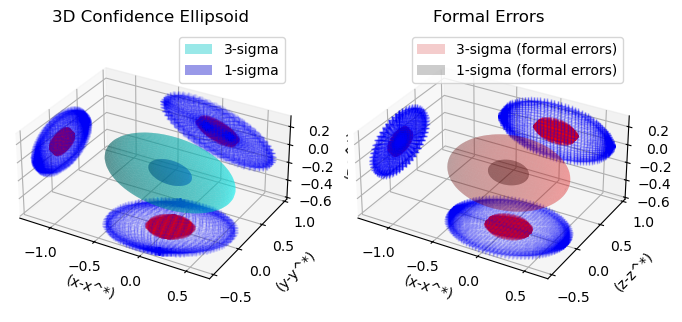

In [55]:
# # Define the parameters
x_star = parameters_to_estimate.parameter_vector # Nominal solution (center of the ellipsoid)
# Create input object for covariance analysis
covariance_input = estimation.CovarianceAnalysisInput(
      simulated_observations)

# # Set methodological options
covariance_input.define_covariance_settings(
     reintegrate_variational_equations=False)
# # Define weighting of the observations in the inversion
covariance_input.set_constant_weight_per_observable(weights_per_observable)
covariance_output = estimator.compute_covariance(covariance_input)
initial_covariance = covariance_output.covariance  # Covariance matrix
print(f'Initial_covariance:\n {initial_covariance}')
"""
Ideally, I would want to propagate the covariance here,
in order to see what happens to the confidence ellipsoid along the orbit.
However, there is a problem with estimation.propagate_covariance, which is needed to propagate the covariance...

>>>>> TypeError: Unregistered type : Eigen::Matrix<double, -1, -1, 0, -1, -1> <<<<<
"""
state_transition_interface = estimator.state_transition_interface
output_times = observation_times

propagated_formal_errors = estimation.propagate_formal_errors_split_output(
    initial_covariance=initial_covariance,
    state_transition_interface=state_transition_interface,
    output_times=output_times)
# Split tuple into epochs and formal errors
epochs = np.array(propagated_formal_errors[0])
propagated_formal_errors = np.array(propagated_formal_errors[1])
diagonal_covariance = np.diag(formal_errors**2)
print(f'Formal Error Matrix:\n{diagonal_covariance}')

sigma = 3  # Confidence level
original_eigenvalues, original_eigenvectors = np.linalg.eig(initial_covariance)
original_diagonal_eigenvalues, original_diagonal_eigenvectors = np.linalg.eig(diagonal_covariance)
print(f'Estimated state and parameters:\n {parameters_to_estimate.parameter_vector}\n')
print(f'Eigenvalues of Covariance Matrix:\n {original_eigenvalues}\n')
print(f'Eigenvalues of Formal Errors Matrix:\n {original_diagonal_eigenvalues}\n')

# # Select the first 3 dimensions for plotting
# Sort eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(original_eigenvalues)[::-1]
diagonal_sorted_indices = np.argsort(original_diagonal_eigenvalues)[::-1]

eigenvalues = original_eigenvalues[sorted_indices]
eigenvectors = original_eigenvectors[:, sorted_indices]

diagonal_eigenvalues = original_diagonal_eigenvalues[diagonal_sorted_indices]
diagonal_eigenvectors = original_diagonal_eigenvectors[:, diagonal_sorted_indices]

# Output results
print(f"Sorted Eigenvalues (variances along principal axes):\n{eigenvalues}")
print(f"Sorted Formal Error Matrix Eigenvalues (variances along principal axes):\n{diagonal_eigenvalues}")
print(f"Sorted Eigenvectors (directions of principal axes):\n{eigenvectors}")
print(f"Sorted Formal Error Matrix Eigenvectors (directions of principal axes):\n{diagonal_eigenvectors}")

# To determine the most uncertain parameter:
most_uncertain_axis = sorted_indices[0]
diagonal_most_uncertain_axis = diagonal_sorted_indices[0]
print(f"Most uncertain parameter corresponds to the principal axis:\n{most_uncertain_axis}")
print(f"Formal Error Most uncertain parameter corresponds to the principal axis:\n{diagonal_most_uncertain_axis}")

print(np.sort(sorted_indices)[:3])
print(np.sort(diagonal_sorted_indices)[:3])

COV_sub = initial_covariance[np.ix_(np.sort(sorted_indices)[:3], np.sort(sorted_indices)[:3])]  #Covariance restriction to first 3 (spatial) eigenvectors
diagonal_COV_sub = diagonal_covariance[np.ix_(np.sort(diagonal_sorted_indices)[:3], np.sort(diagonal_sorted_indices)[:3])]  #Covariance restriction to first 3 (spatial) eigenvectors

x_star_sub = x_star[indices] #Nominal solution subset
diagonal_x_star_sub = x_star_sub[diagonal_indices] #Nominal solution subset

# Eigenvalue decomposition of the submatrix
eigenvalues, eigenvectors = np.linalg.eig(COV_sub)
diagonal_eigenvalues, diagonal_eigenvectors = np.linalg.eigh(diagonal_COV_sub)
#eigenvectors = eigenvectors*np.sqrt(1 / eigenvalues)
# Ensure eigenvalues are positive
if np.any(eigenvalues <= 0):
     raise ValueError(f"$Covariance$ submatrix is not positive definite. Eigenvalues must be positive.\n")
# Create the transformation matrix A = Q * sqrt(Λ)

if np.any(diagonal_eigenvalues <= 0):
    raise ValueError(f"$Formal Errors$ submatrix is not positive definite. Eigenvalues must be positive.\n")
# Create the transformation matrix A = Q * sqrt(Λ)

A = eigenvectors @ np.diag(np.sqrt(eigenvalues))
diagonal_A = diagonal_eigenvectors @ np.diag(np.sqrt(diagonal_eigenvalues))
# Generate points on the unit sphere
phi = np.linspace(0, np.pi, 50)
theta = np.linspace(0, 2 * np.pi, 50)
phi, theta = np.meshgrid(phi, theta)
x_sphere = np.sin(phi) * np.cos(theta)
y_sphere = np.sin(phi) * np.sin(theta)
z_sphere = np.cos(phi)
sphere = np.stack([x_sphere, y_sphere, z_sphere], axis=0)
# Transform the unit sphere to the ellipsoid
ellipsoid_boundary_3_sigma = x_star_sub[:, np.newaxis, np.newaxis] + 3 * np.tensordot(A, sphere, axes=1) - x_star_sub[:, np.newaxis, np.newaxis]
ellipsoid_boundary_1_sigma = x_star_sub[:, np.newaxis, np.newaxis] + 1 * np.tensordot(A, sphere, axes=1) - x_star_sub[:, np.newaxis, np.newaxis]

diagonal_ellipsoid_boundary_3_sigma = diagonal_x_star_sub[:, np.newaxis, np.newaxis] + 3 * np.tensordot(diagonal_A, sphere, axes=1) - diagonal_x_star_sub[:, np.newaxis, np.newaxis]
diagonal_ellipsoid_boundary_1_sigma = diagonal_x_star_sub[:, np.newaxis, np.newaxis] + 1 * np.tensordot(diagonal_A, sphere, axes=1) - diagonal_x_star_sub[:, np.newaxis, np.newaxis]

# Plot the ellipsoid in 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(121, projection='3d')
diagonal_ax =fig.add_subplot(122, projection='3d')

ax.plot_surface(ellipsoid_boundary_3_sigma[0], ellipsoid_boundary_3_sigma[1], ellipsoid_boundary_3_sigma[2], color='cyan', alpha=0.4, label = '3-sigma')
ax.plot_surface(ellipsoid_boundary_1_sigma[0], ellipsoid_boundary_1_sigma[1], ellipsoid_boundary_1_sigma[2], color='blue', alpha=0.4, label = '1-sigma')
diagonal_ax.plot_surface(diagonal_ellipsoid_boundary_3_sigma[0], diagonal_ellipsoid_boundary_3_sigma[1], diagonal_ellipsoid_boundary_3_sigma[2], color='red', alpha=0.2, label = '3-sigma (formal errors)')
diagonal_ax.plot_surface(diagonal_ellipsoid_boundary_1_sigma[0], diagonal_ellipsoid_boundary_1_sigma[1], diagonal_ellipsoid_boundary_1_sigma[2], color='black', alpha=0.2, label = '1-sigma (formal errors)')

ax.plot(ellipsoid_boundary_1_sigma[0], ellipsoid_boundary_1_sigma[2], 'r+', alpha=0.1, zdir='y', zs=2*np.max(ellipsoid_boundary_3_sigma[1]))
ax.plot(ellipsoid_boundary_1_sigma[1], ellipsoid_boundary_1_sigma[2], 'r+',alpha=0.1, zdir='x', zs=-2*np.max(ellipsoid_boundary_3_sigma[0]))
ax.plot(ellipsoid_boundary_1_sigma[0], ellipsoid_boundary_1_sigma[1], 'r+',alpha=0.1, zdir='z', zs=-2*np.max(ellipsoid_boundary_3_sigma[2]))

ax.plot(ellipsoid_boundary_3_sigma[0], ellipsoid_boundary_3_sigma[2], 'b+', alpha=0.1, zdir='y', zs=2*np.max(ellipsoid_boundary_3_sigma[1]))
ax.plot(ellipsoid_boundary_3_sigma[1], ellipsoid_boundary_3_sigma[2], 'b+',alpha=0.1, zdir='x', zs=-2*np.max(ellipsoid_boundary_3_sigma[0]))
ax.plot(ellipsoid_boundary_3_sigma[0], ellipsoid_boundary_3_sigma[1], 'b+',alpha=0.1, zdir='z', zs=-2*np.max(ellipsoid_boundary_3_sigma[2]))

diagonal_ax.plot(diagonal_ellipsoid_boundary_1_sigma[0], diagonal_ellipsoid_boundary_1_sigma[2], 'r+', alpha=0.1, zdir='y', zs=2*np.max(diagonal_ellipsoid_boundary_3_sigma[1]))
diagonal_ax.plot(diagonal_ellipsoid_boundary_1_sigma[1], diagonal_ellipsoid_boundary_1_sigma[2], 'r+',alpha=0.1, zdir='x', zs=-2*np.max(diagonal_ellipsoid_boundary_3_sigma[0]))
diagonal_ax.plot(diagonal_ellipsoid_boundary_1_sigma[0], diagonal_ellipsoid_boundary_1_sigma[1], 'r+',alpha=0.1, zdir='z', zs=-2*np.max(diagonal_ellipsoid_boundary_3_sigma[2]))

diagonal_ax.plot(diagonal_ellipsoid_boundary_3_sigma[0], diagonal_ellipsoid_boundary_3_sigma[2], 'b+', alpha=0.1, zdir='y', zs=2*np.max(diagonal_ellipsoid_boundary_3_sigma[1]))
diagonal_ax.plot(diagonal_ellipsoid_boundary_3_sigma[1], diagonal_ellipsoid_boundary_3_sigma[2], 'b+',alpha=0.1, zdir='x', zs=-2*np.max(diagonal_ellipsoid_boundary_3_sigma[0]))
diagonal_ax.plot(diagonal_ellipsoid_boundary_3_sigma[0], diagonal_ellipsoid_boundary_3_sigma[1], 'b+',alpha=0.1, zdir='z', zs=-2*np.max(diagonal_ellipsoid_boundary_3_sigma[2]))

#ax.scatter(x_star_sub[0], x_star_sub[1], x_star_sub[2], color='red', label='Nominal Solution (x*)')
#diagonal_ax.scatter(diagonal_x_star_sub[0], diagonal_x_star_sub[1], diagonal_x_star_sub[2], color='red', label='Nominal Solution (x*)')

ax.set_xlabel('(x-x^*)')
ax.set_ylabel('(y-y^*)')
ax.set_zlabel('(z-z^*)')
ax.set_aspect('equal')
ax.set_title('3D Confidence Ellipsoid')
ax.set_aspect('equal')
ax.legend(loc = 'upper right')

diagonal_ax.set_xlabel('(x-x^*)')
diagonal_ax.set_ylabel('(z-z^*)')
diagonal_ax.set_zlabel('(z-z^*)')
diagonal_ax.set_aspect('equal')
diagonal_ax.set_title('Formal Errors')
diagonal_ax.set_aspect('equal')
diagonal_ax.legend(loc = 'upper right')
plt.legend()
plt.show()

### Range-rate over time
First, we will thus plot all simulations we have simulated over time. One can clearly see how the satellite slowly emerges from the horizont and then more 'quickly' passes the station, until the visibility criterion is not fulfilled anymore.

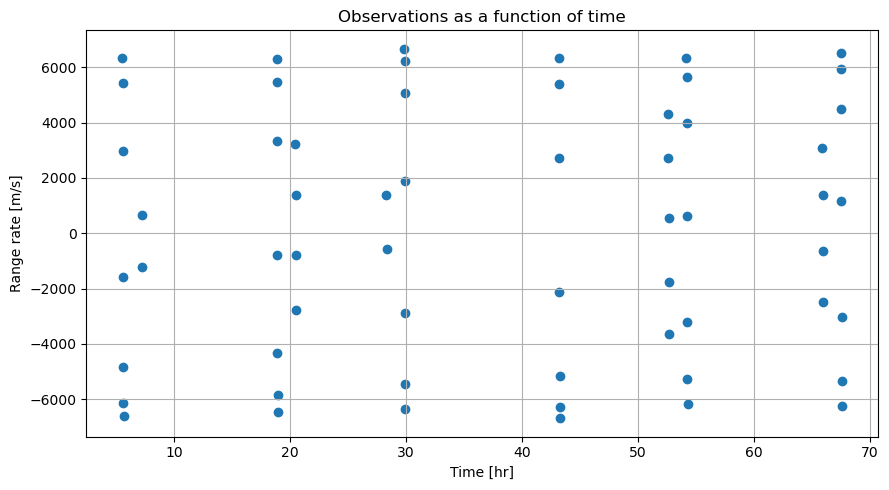

In [56]:
observation_times = np.array(simulated_observations.concatenated_times)
observations_list = np.array(simulated_observations.concatenated_observations)

plt.figure(figsize=(9, 5))
plt.title("Observations as a function of time")
plt.scatter(observation_times / 3600.0, observations_list)

plt.xlabel("Time [hr]")
plt.ylabel("Range rate [m/s]")
plt.grid()

plt.tight_layout()
plt.show()

### Residuals history
One might also opt to instead plot the behaviour of the residuals per iteration of the estimator. To this end, we have thus plotted the residuals of the individual observations as a function of time. Note that we can observe a seemingly equal spread around zero. As expected - since we have not defined it this way - the observation is thus not biased.

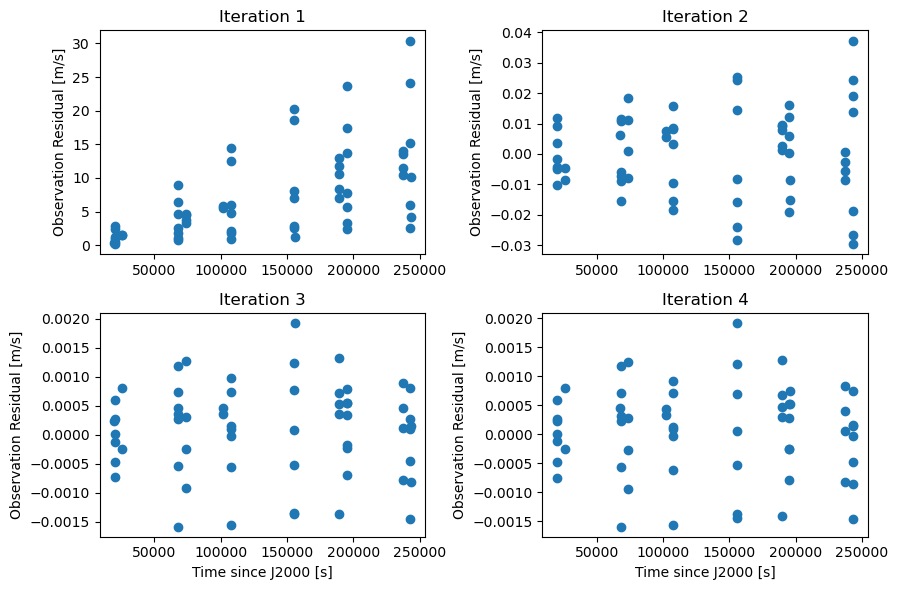

In [57]:
residual_history = estimation_output.residual_history

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 6))
subplots_list = [ax1, ax2, ax3, ax4]

for i in range(4):
    subplots_list[i].scatter(observation_times, residual_history[:, i])
    subplots_list[i].set_ylabel("Observation Residual [m/s]")
    subplots_list[i].set_title("Iteration "+str(i+1))


ax3.set_xlabel("Time since J2000 [s]")
ax4.set_xlabel("Time since J2000 [s]")


plt.tight_layout()
plt.show()

### Final residuals
Finally, one can also analyse the residuals of the last iteration. Hence, for each of the estimated parameters, we have calculated the true-to-formal-error rate, as well as plotted the statistical distribution of the final residuals between the simulated observations and the estimated orbit. Ideally, given the type of observable we have used (i.e. free of any bias) as well as a statistically sufficient high number of observations, we would expect to see a Gaussian distribution with zero mean here.

True-to-formal-error ratio:

Initial state
[-0.66627016 -0.03927936  1.3968208   0.41364537 -2.09235415 -0.7473061 ]

Physical parameters
[-0.95629081  1.2421565 ]


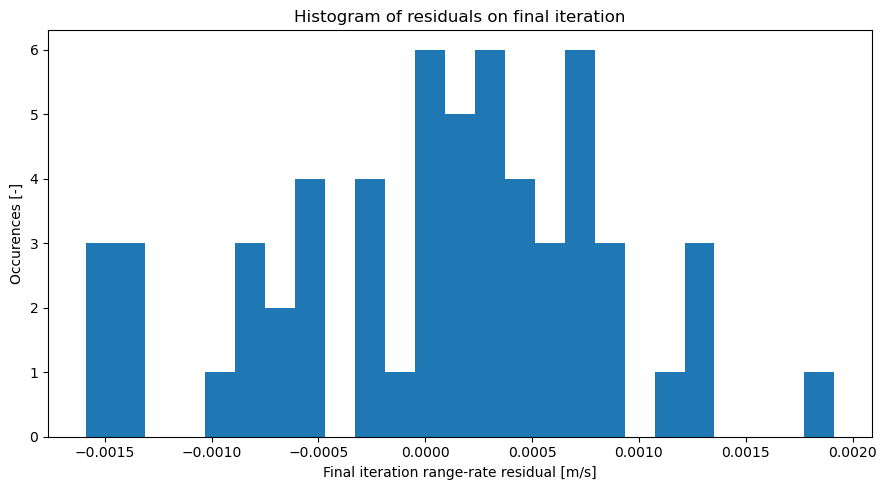

In [58]:
print('True-to-formal-error ratio:')
print('\nInitial state')
print(((truth_parameters - parameters_to_estimate.parameter_vector) / estimation_output.formal_errors)[:6])
print('\nPhysical parameters')
print(((truth_parameters - parameters_to_estimate.parameter_vector) / estimation_output.formal_errors)[6:])

final_residuals = estimation_output.final_residuals

plt.figure(figsize=(9,5))
plt.hist(final_residuals, 25)
plt.xlabel('Final iteration range-rate residual [m/s]')
plt.ylabel('Occurences [-]')
plt.title('Histogram of residuals on final iteration')

plt.tight_layout()
plt.show()